<h1>Mental Health Model Trainer Notebook</h1>
<h3>Training the model based on data scraped from the US Census Bureau</h3>
<h2><b>IMPORTANT:</b><br><span style="color:red;">This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.</span></h2>

<ol>
    <li>Split the data into training, test, and validation sets (done in a different notebook)</li>
    <ul>
        <li>4 fold cross validation - 80% of the data with training = 60%, validation = 20%</li>
        <li>Test = 20%</li>
    </ul>
    <li>Train the model based on broadband internet only, normalize y value, minimize MSE</li>
    <li>Use LASSO regularizatio|n to eliminate unecessary features from the theta vector</li>
    <li>Retrain the model with demographic features added in</li>
    <li>Retrain the model with economic features added in</li>
    <li>Retrain the model with social features added in</li>
</ol>

In [103]:
#Imports
#Data manipulation/training
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

#Visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore') #Turn off warnings

<h2>Defining Helper Functions and Classes</h2>

In [104]:
class Transformation:
    """Transformation class to represent the transformation on one variable"""
    
    def __init__(self, transformation, transformation_name, inverse, inverse_name):
        """
        Parameters
        ----------
        transformation : def (x: arraylike<float>) -> arraylike<float>
            the transformation function to apply to an float array
            
        transformation_name : string
            the name of the transformation
            
        inverse : def (x: arraylike<float>) -> arraylike<float>
            the inverse function which can undo the transformation
            
        inverse_name : string
            the name of the inverse transformation
        """
        
        self.transformation = transformation
        self.transformation_name = transformation_name
        self.inverse = inverse
        self.inverse_name = inverse_name

"""Utility Transformation objects"""
no_transformation = Transformation(lambda x: x, "", lambda x: x, "")
square = Transformation(lambda x: x**2, "The Square of", lambda x: x**0.5, "The Square Root of")
cube = Transformation(lambda x: x**3, "The Cube of", lambda x: x**(1/3), "The Cube Root of")
fourth = Transformation(lambda x: x**4, "The Fourth Power of", lambda x: x**0.25, "The Fourth Root of")
square_root = Transformation(lambda x: x**0.5, "The Square Root of", lambda x: x**2, "The Square of")
cube_root = Transformation(lambda x: x**(1/3), "The Cube Root of", lambda x: x**3, "The Cube of")
fourth_root = Transformation(lambda x: x**0.25, "The Fourth Root of", lambda x: x**4, "The Fourth Power of")
log = Transformation(lambda x: np.log(x), "The Natural Log of", lambda x: np.exp(x), "e to the Power of")
e_power = Transformation(lambda x: np.exp(x), "e to the Power of", lambda x: np.log(x), "The Natural Log of")
log_square_root = Transformation(lambda x: np.log(np.sqrt(x)), "The Log of the Square Root of", lambda x: np.exp(x) ** 2, "e to the Power of 2 Times")


"""Defining the Y feature"""
Y_name = "Individuals Age 18+ with Mental Health not Good for 14+ Days (%)"

def wrap_label(axis_name):
    """Wraps an label that is too long by adding newline characters
    
    Parameters
    ----------
    axis_name: string
    """
    words = axis_name.split()
    final_label = ""
    for i in range(len(words)):
        if i % 9 == 0 and i != 0:
            final_label += "\n"
        final_label += f"{words[i]} "
    return final_label

def plot_relationship(X_feature, Y, X_transformation=no_transformation, Y_transformation=no_transformation, imp_val=0):
    """Plots the relationship between an (optionally) transformation X feature and Y outcome
    
    If no transformation object is passed in, it assumed no transformation
    
    Parameters
    ----------
    X_feature : arraylike<float>
        The predictor variable
    
    Y : arraylike<float>
        The outcome variable
    
    X_transformation : Transformation
        The Transformation to apply to the X_feature
    
    Y_transformation : Transformation
        The Transformation to apply to the Y_feature
        
    Return Value
    ------------
    None
    """
    X_feature = impute_col(X_feature, imp_val)
    X_transformed = X_transformation.transformation(X_feature)
    Y_transformed = Y_transformation.transformation(Y)
    x_axis_name = f"{X_transformation.transformation_name} {X_feature.name}"
    y_axis_name = f"{Y_transformation.transformation_name} {Y.name}"
    fig_data = pd.DataFrame({x_axis_name : X_transformed, y_axis_name: Y_transformed})
    fig = sns.lmplot(data=fig_data, 
                     x=x_axis_name, 
                     y=y_axis_name, 
                     height=10, 
                     scatter_kws={
                         's': 0.7, 
                         'alpha': 0.4
                     },
                    )
    fig.set_xlabels(wrap_label(x_axis_name), fontsize=18)
    fig.set_ylabels(y_axis_name, fontsize=18)
    plt.show()

def plot_residuals(X_feature, Y, X_transformation=no_transformation, Y_transformation=no_transformation, axis="X"):
    """Plots the residuals on a model trained on an (optionally) transformed X feature and Y outcome
    
    If no transformation object is passed in, it assumed no transformation
    
    Parameters
    ----------
    X_feature : arraylike<float>
        The predictor variable
    
    Y : arraylike<float>
        The outcome variable
    
    X_transformation : Transformation
        The Transformation to apply to the X_feature
    
    Y_transformation : Transformation
        The Transformation to apply to the Y_feature
        
    Return Value
    ------------
    None
    """
    X_transformed = X_transformation.transformation(X_feature)
    Y_transformed = Y_transformation.transformation(Y)
    y_axis_name = f"{Y_transformation.transformation_name} {Y.name}"
    x_axis_name = f"{X_transformation.transformation_name} {X_feature.name}"
    design_matrix = pd.DataFrame({x_axis_name: X_transformed})
    model = LinearRegression()
    model.fit(design_matrix, Y_transformed)
    predictions = model.predict(design_matrix)
    residuals = Y - Y_transformation.inverse(predictions)
    if axis == "X":
        fig_data = pd.DataFrame({x_axis_name : X_transformed, "Residual": residuals})
        fig = sns.lmplot(data=fig_data, 
                         x=x_axis_name, 
                         y="Residual", 
                         height=10, 
                         scatter_kws={
                             's': 0.7, 
                             'alpha': 0.4
                         },
                        )
        fig.set_xlabels(wrap_x_label(x_axis_name), fontsize=18)
        fig.set_ylabels("Residual", fontsize=18)
    else:
        fig_data = pd.DataFrame({Y.name: Y, "Residual": residuals})
        fig = sns.lmplot(data=fig_data, 
                         x=Y.name, 
                         y="Residual", 
                         height=10, 
                         scatter_kws={
                             's': 0.7, 
                             'alpha': 0.4
                         },
                        )
        fig.set_xlabels(wrap_x_label(y_axis_name), fontsize=18)
        fig.set_ylabels("Residual", fontsize=18)

def rmse(actual, predicted):
    """Computes the RMSE for an actual and predicted Y and Y hat
    
    Parameters
    ----------
    actual: arraylike<float>
        Y vector for a model
    
    predicted: arraylike<float>
        Y hat vector for a model
        
    Constraints
    -----------
    len(actual) == len(predicted)
    
    Return Value
    ------------
    float
    """
    return np.sqrt(np.mean((actual - predicted) ** 2))

def get_features(feature_set):
    """Returns a list with all the features based on the feature_Set
    
    Parameters
    ----------
    feature_set: list<string>
        The selected features for the model (out of 'initial', 'economic', 'social', and 'demographic'
    
    Return Value
    ------------
    list<string>
    """
    
    #Selecting the features
    feature_list = []
    if "initial" in feature_set:
        feature_list.extend(initial_features)
    if "social" in feature_set:
        feature_list.extend(social_features)
    if "demographic" in feature_set:
        feature_list.extend(demographic_features)
    if "economic" in feature_set:
        feature_list.extend(economic_features)
    
    return feature_list
        
def train_model(X, Y, Y_transformation=no_transformation):
    """Trains the model based on a preprocessed X matrix and Y vector
    
    Prints the training error as well as validation error across 4 folds
    
    Parameters
    ----------
    X: DataFrame
        The preprocessed design matrix for the model
        
    Y: arraylike<float>
        The outcome variable to be predicted
        
    Y_transformation: Transformation
        A transformation to apply to the Y value and to unapply to the predictions
    
    Return Value
    ------------
    None
    """
    
    model = LinearRegression()
    Y_t = Y_transformation.transformation(Y)
    model.fit(X, Y_t)
    train_predictions = Y_transformation.inverse(model.predict(X))
    train_error = rmse(Y, train_predictions)
    print(f"Training Error: {train_error}")
    fold_counter = 1
    avg_cv_error = 0
    for train, val in cross_validation.split(X, Y_t):
        X_train = X.loc[X.index[train]]
        X_val = X.loc[X.index[val]]
        Y_train = Y_t.loc[Y_t.index[train]]
        Y_val = Y_t.loc[Y_t.index[val]]
        model.fit(X_train, Y_train)
        predictions = Y_transformation.inverse(model.predict(X_val))
        fold_rmse = rmse(Y_transformation.inverse(Y_val), predictions)
        print(f"Fold {fold_counter} validation error: {fold_rmse}")
        fold_counter += 1
        avg_cv_error += fold_rmse
    print(f"Average Cross Validation Error: {avg_cv_error / (fold_counter - 1)}")
    return model

def impute(df, x_col, impute_num):
    df = df.copy()
    mean_value = df[x_col].mean()
    df[x_col] = df[x_col].replace(impute_num, mean_value)
    return df

def impute_col(arr, impute_num):
    arr = arr.copy()
    arr[arr == impute_num] = np.mean(arr)
    return arr

In [105]:
X_train = pd.read_csv("./X_train_val.csv", index_col="ZCTA")
Y_train = pd.read_csv("./Y_train_val.csv", index_col="ZCTA")[[Y_name]]
cross_validation = KFold(n_splits=4)
with open('./codebooks/initial_features.txt', 'r') as file:
    initial_features =  [line.strip() for line in file.readlines()]
with open('./codebooks/economic_features.txt', 'r') as file:
    economic_features = [line.strip() for line in file.readlines()]
with open('./codebooks/demographic_features.txt', 'r') as file:
    demographic_features = [line.strip() for line in file.readlines()]
with open('./codebooks/social_features.txt', 'r') as file:
    social_features = [line.strip() for line in file.readlines()]

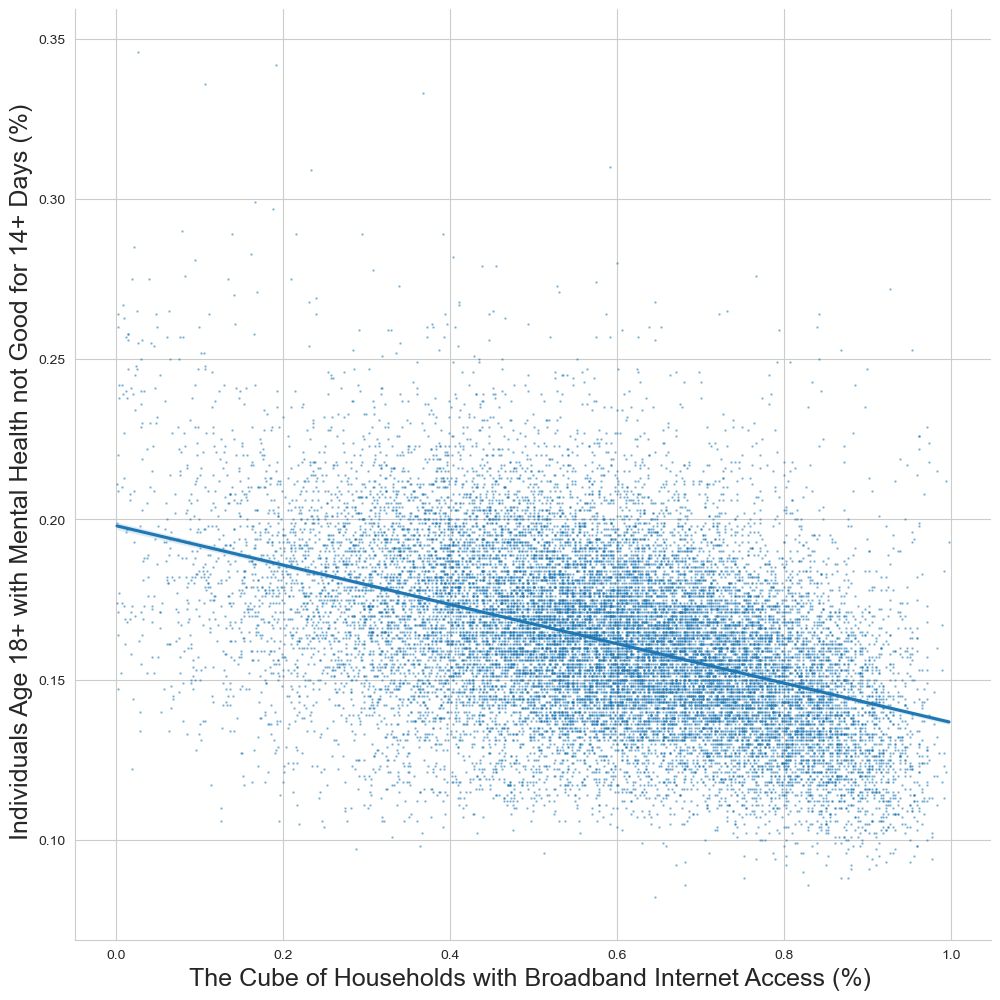

In [106]:
plot_relationship(X_train["Households with Broadband Internet Access (%)"], 
                  Y_train[Y_name],
                  X_transformation=cube)

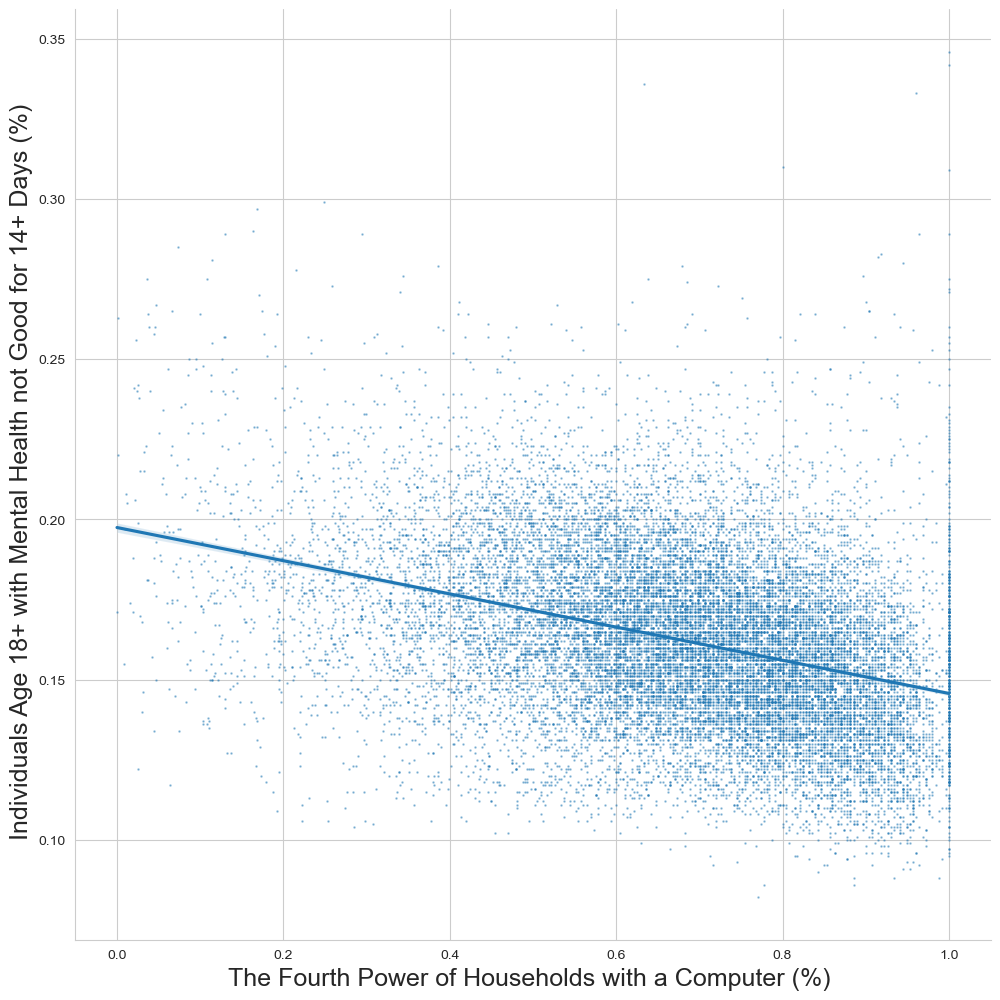

In [107]:
plot_relationship(X_train["Households with a Computer (%)"], 
                  Y_train[Y_name],
                  X_transformation=fourth)
#Not using because linear relationship not clear enough

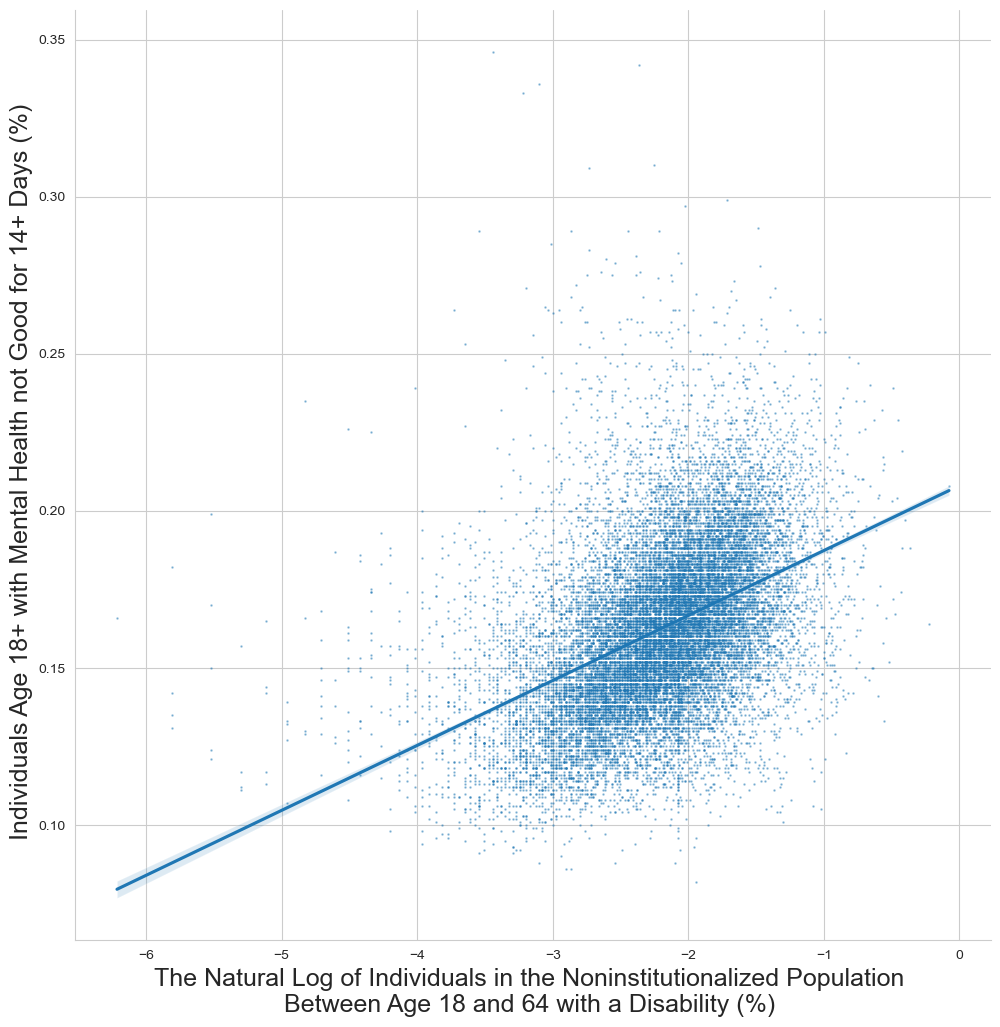

In [108]:
plot_relationship(X_train["Individuals in the Noninstitutionalized Population Between Age 18 and 64 with a Disability (%)"], 
                  Y_train[Y_name],
                  X_transformation=log)

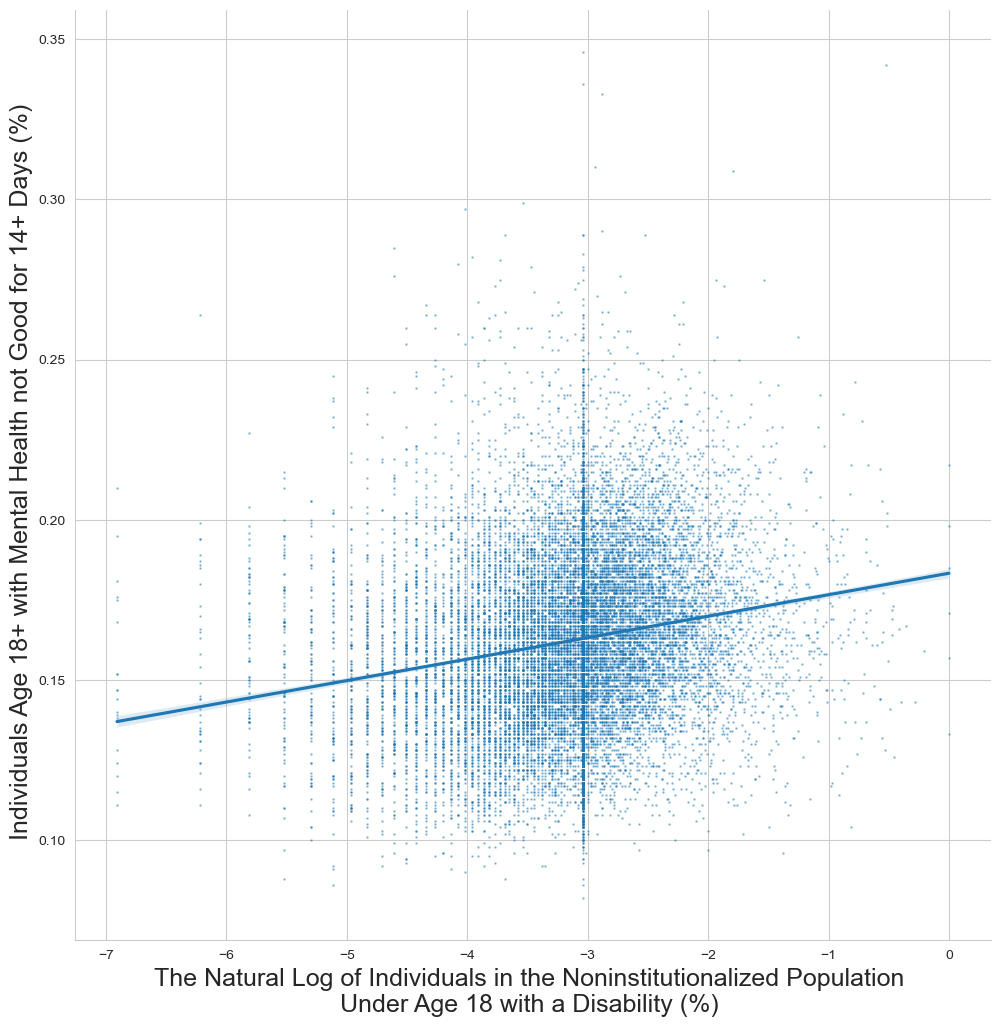

In [109]:
plot_relationship(impute(X_train, "Individuals in the Noninstitutionalized Population Under Age 18 with a Disability (%)", 0)["Individuals in the Noninstitutionalized Population Under Age 18 with a Disability (%)"], 
                  Y_train[Y_name],
                  X_transformation=log)
#probably not using, relationship is too weird

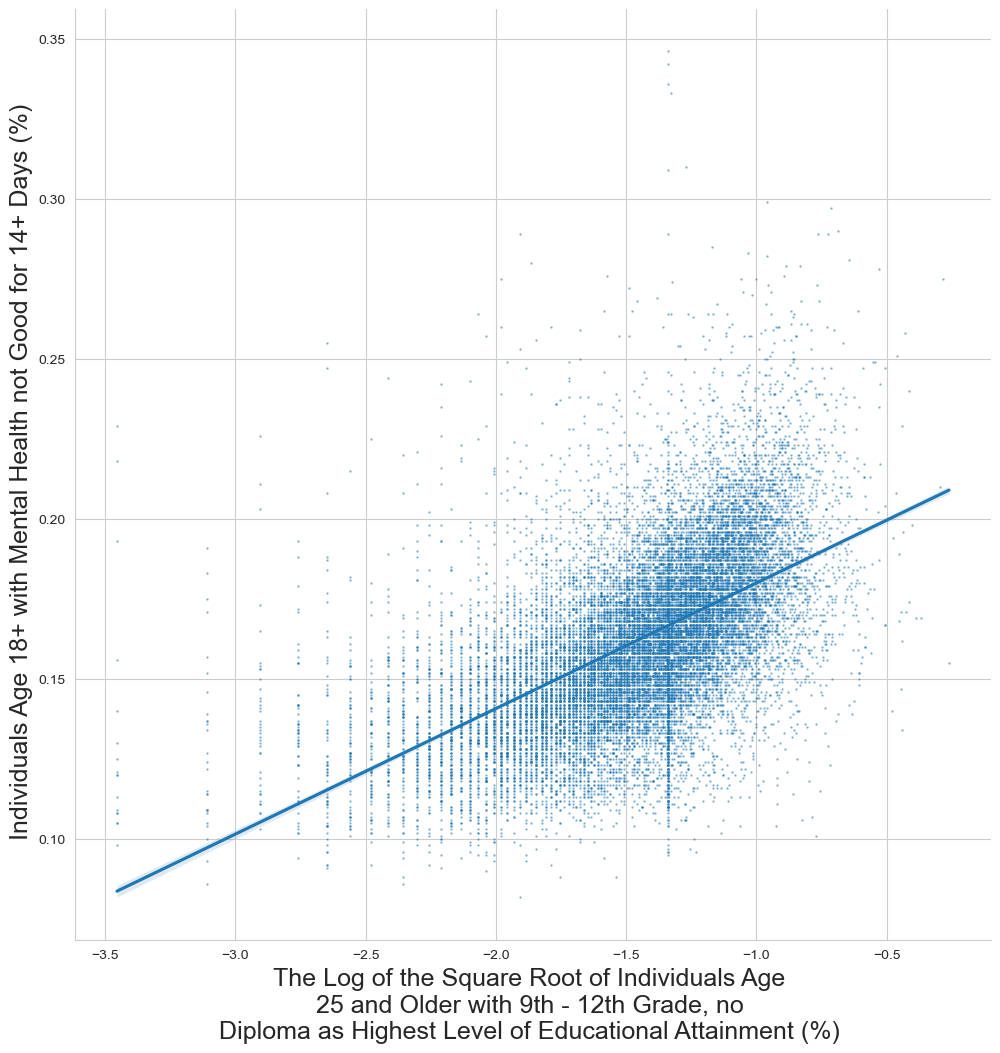

In [110]:
plot_relationship(X_train["Individuals Age 25 and Older with 9th - 12th Grade, no Diploma as Highest Level of Educational Attainment (%)"], 
                  Y_train[Y_name],
                  X_transformation=log_square_root)
#Not using this feature, not linear

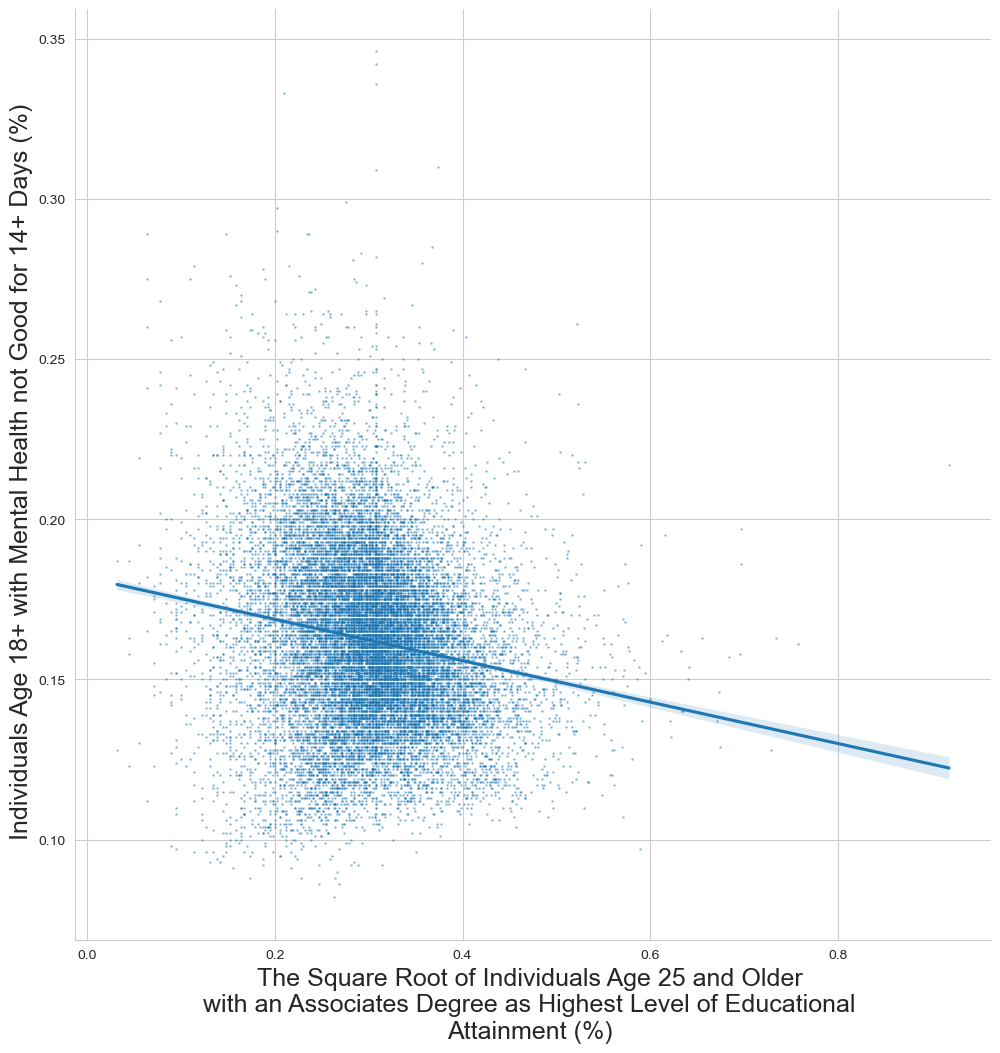

In [111]:
plot_relationship(X_train["Individuals Age 25 and Older with an Associates Degree as Highest Level of Educational Attainment (%)"], 
                  Y_train[Y_name],
                  X_transformation=square_root)
#Not using, no relationship

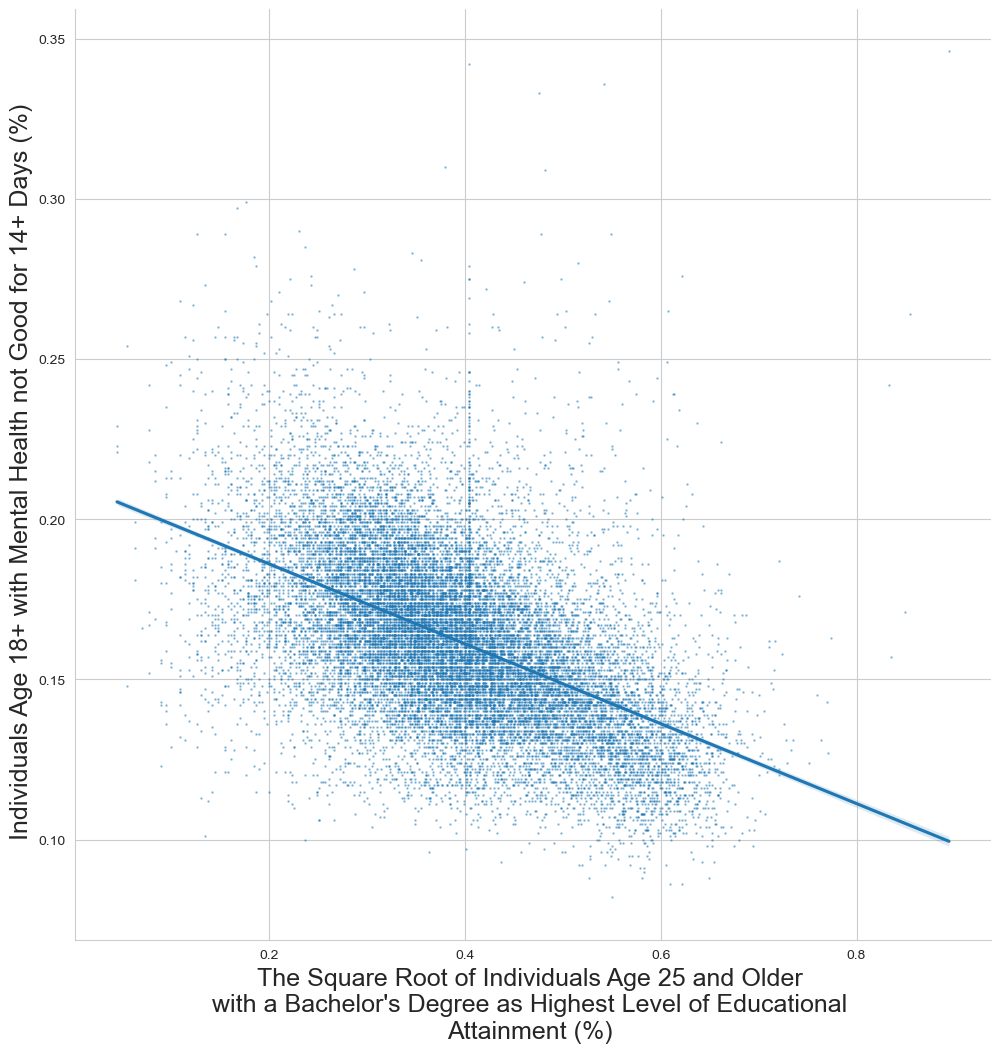

In [112]:
plot_relationship(X_train["Individuals Age 25 and Older with a Bachelor's Degree as Highest Level of Educational Attainment (%)"], 
                  Y_train[Y_name],
                  X_transformation=square_root)
#Using, looks linear to me

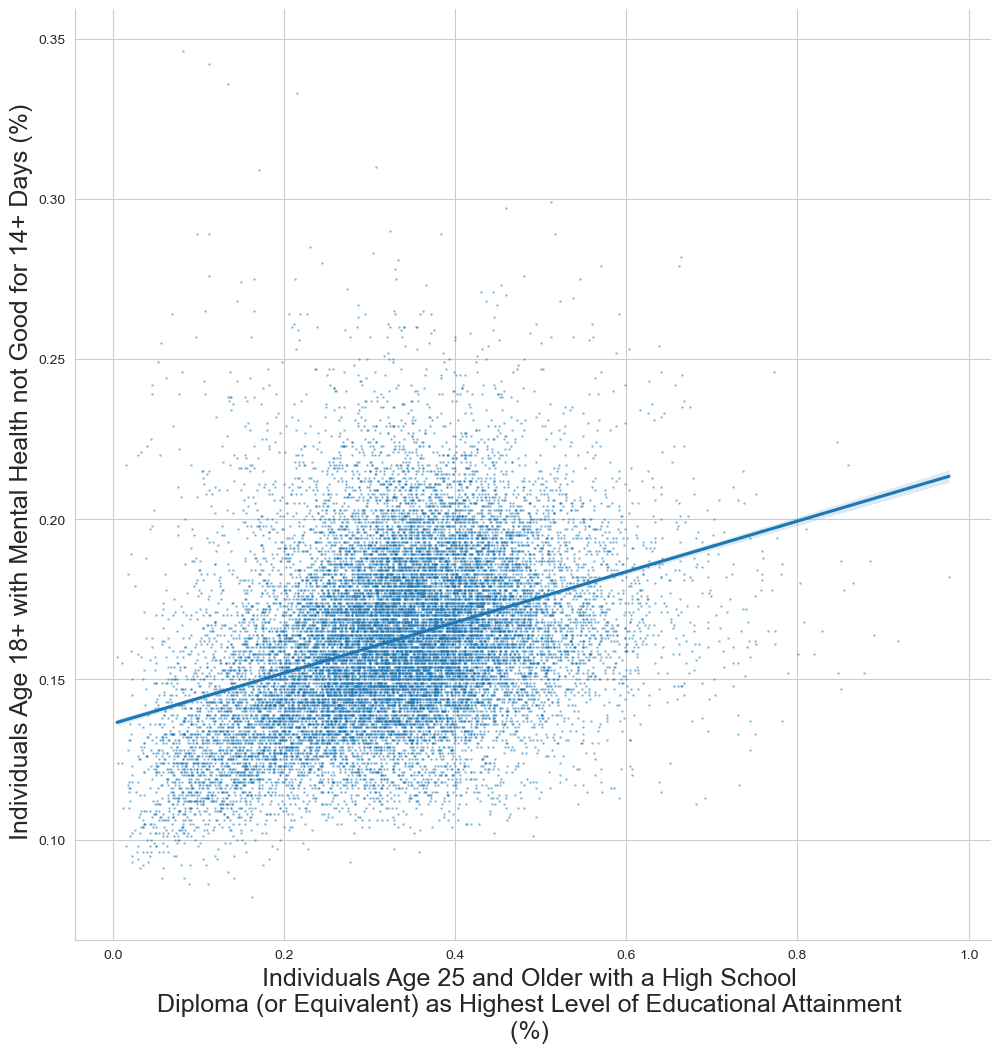

In [113]:
plot_relationship(X_train["Individuals Age 25 and Older with a High School Diploma (or Equivalent) as Highest Level of Educational Attainment (%)"], 
                  Y_train[Y_name],
                  X_transformation=no_transformation)
#Using, close to linear

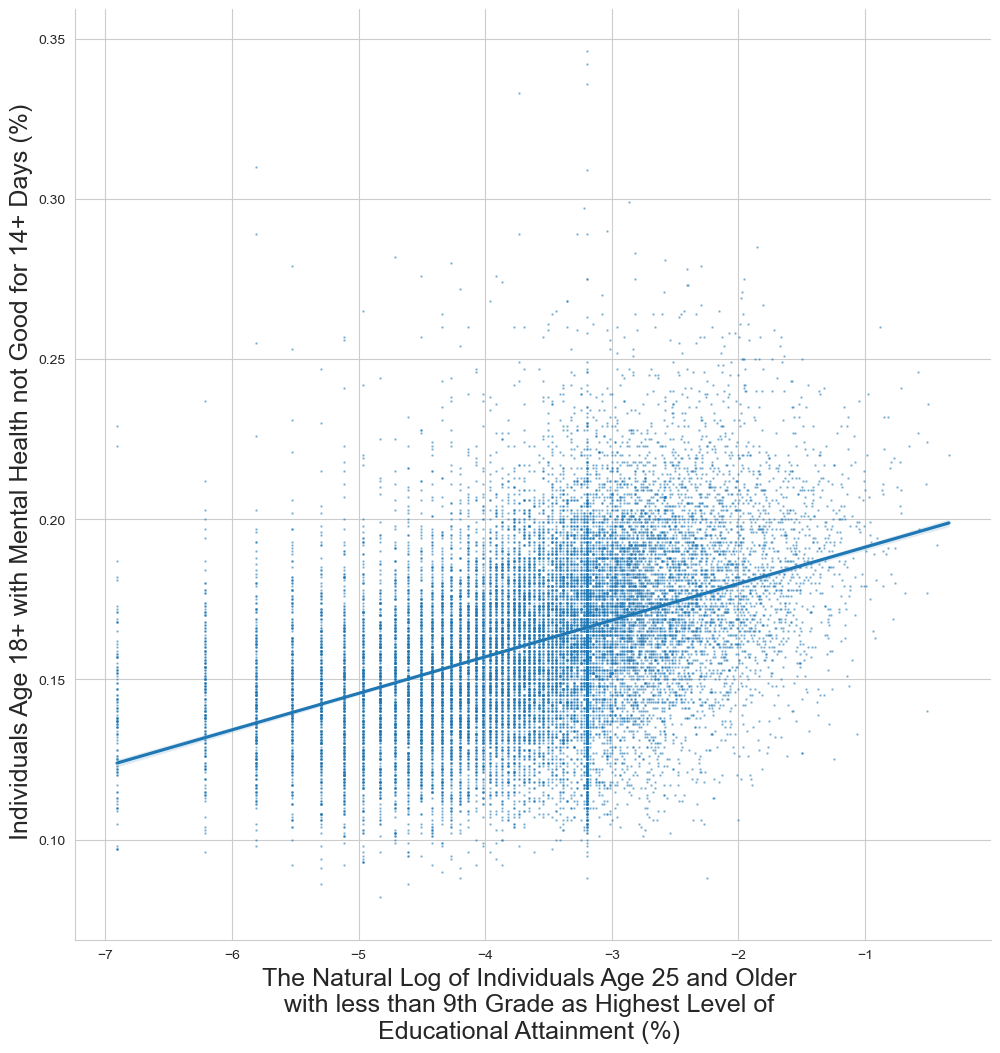

In [114]:
plot_relationship(X_train["Individuals Age 25 and Older with less than 9th Grade as Highest Level of Educational Attainment (%)"], 
                  Y_train[Y_name],
                  X_transformation=log)
#Using, looks pretty linear

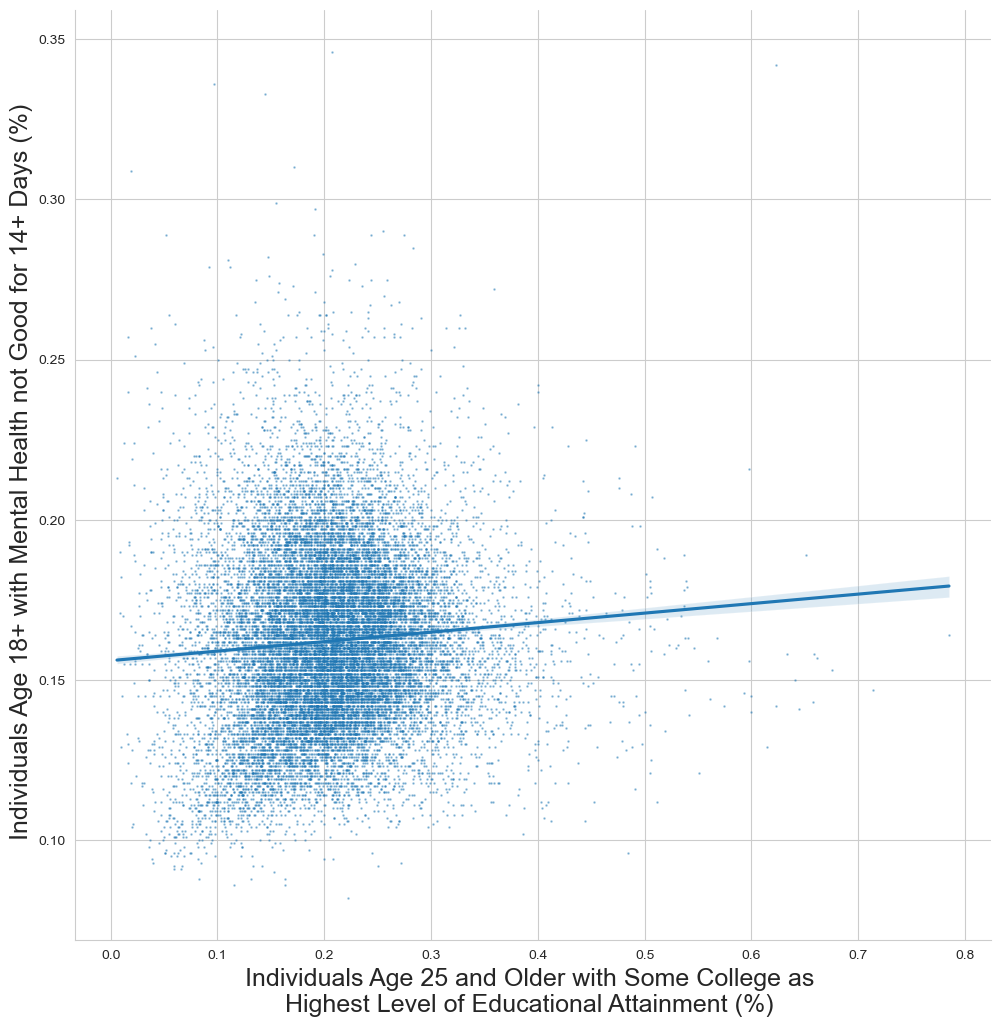

In [115]:
plot_relationship(X_train["Individuals Age 25 and Older with Some College as Highest Level of Educational Attainment (%)"], 
                  Y_train[Y_name],
                  X_transformation=no_transformation)
#Not using, no relationship

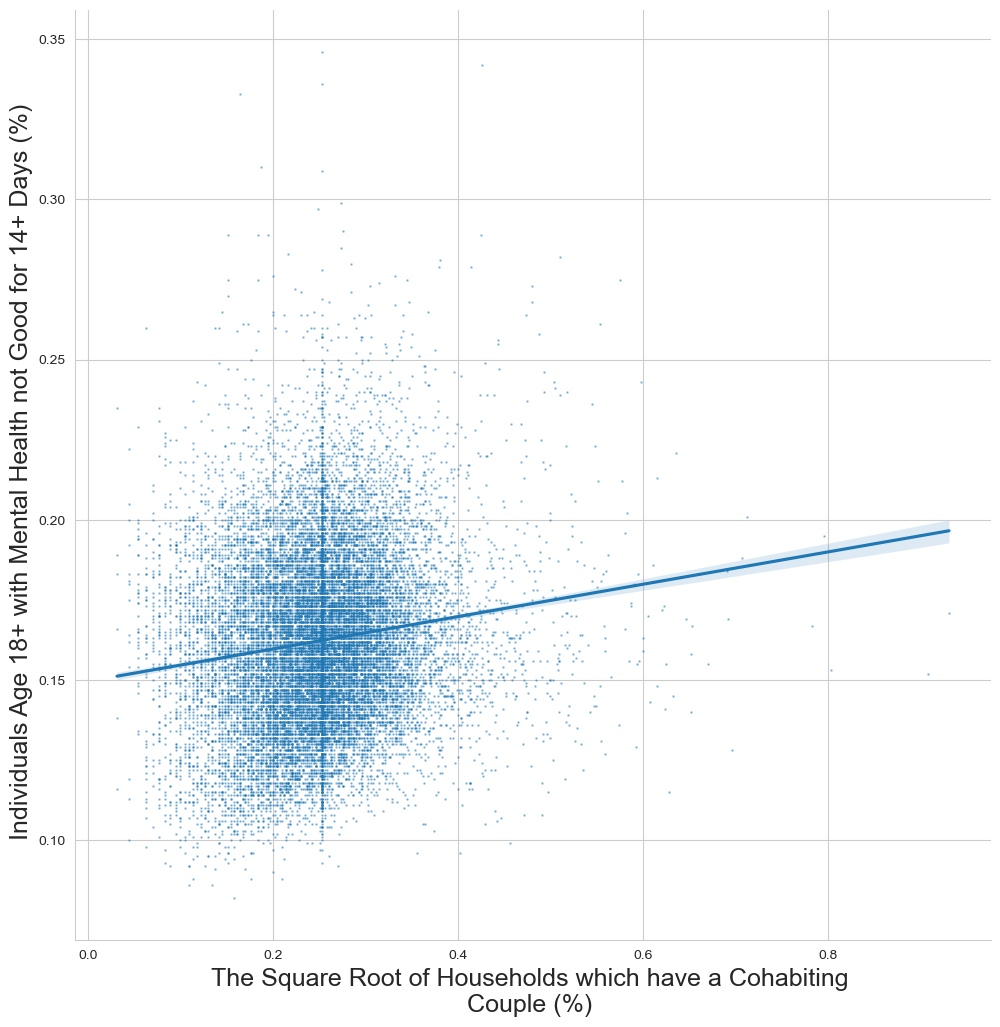

In [116]:
plot_relationship(X_train["Households which have a Cohabiting Couple (%)"], 
                  Y_train[Y_name],
                  X_transformation=square_root)
#Not using, no relationship

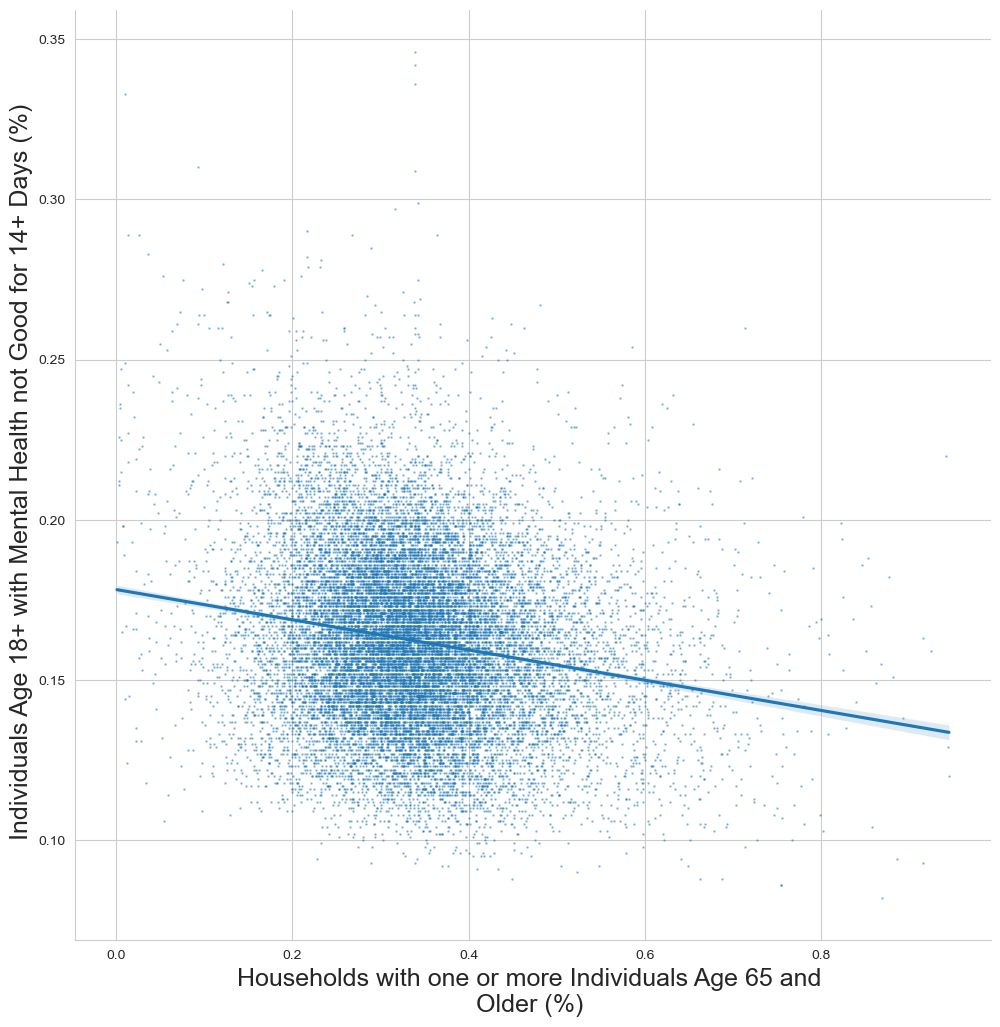

In [117]:
plot_relationship(X_train["Households with one or more Individuals Age 65 and Older (%)"], 
                  Y_train[Y_name],
                  X_transformation=no_transformation)

<h2>Preprocessing and Model Training</h2>

In [120]:
def process_design_matrix(X, feature_set, is_test_set=False):
    """Completes the data engineering on the initial design matrix and returns the new design matrix to train the model on
    
    Parameters
    ----------
    X: DataFrame
        The unprocessed design matrix for the data
    
    is_test_set: boolean
        Whether or not the X dataframe is a test set
    
    Return Value
    ------------
    DataFrame
    """
    X = X.copy()
    
    # Selecting the features
    feature_list = get_features(feature_set)
    X = X[feature_list]
    
    # Add to this list as the processing is done for each feature in feature_set
    final_features = []
    
    # Processing for initial features
    if "initial" in feature_set:
        X = impute(X, "Households with Broadband Internet Access (%)", 1)
        final_features.extend(initial_features)
    
    # Processing for social_features
    if "social" in feature_set:
        X = impute(X, "Individuals in the Noninstitutionalized Population Between Age 18 and 64 with a Disability (%)", 0)
        X["Log 18-64 With a Disability"] = np.log(X["Individuals in the Noninstitutionalized Population Between Age 18 and 64 with a Disability (%)"])
        final_features.append("Log 18-64 With a Disability")
        
        X = impute(X, "Individuals Age 25 and Older with a Bachelor's Degree as Highest Level of Educational Attainment (%)", 0)
        X["Square Root Over 25 With Bachelor's"] = np.sqrt(X["Individuals Age 25 and Older with a Bachelor's Degree as Highest Level of Educational Attainment (%)"])
        final_features.append("Square Root Over 25 With Bachelor's")
        
        X = impute(X, "Individuals Age 25 and Older with a High School Diploma (or Equivalent) as Highest Level of Educational Attainment (%)", 0)
        final_features.append("Individuals Age 25 and Older with a High School Diploma (or Equivalent) as Highest Level of Educational Attainment (%)")
        
        X = impute(X, "Individuals Age 25 and Older with less than 9th Grade as Highest Level of Educational Attainment (%)", 0)
        X["Log Over 25 Less Than 9th Grade"] = np.log(X["Individuals Age 25 and Older with less than 9th Grade as Highest Level of Educational Attainment (%)"])
        final_features.append("Log Over 25 Less Than 9th Grade")
        
    
    # Processing for economic features
    if "economic" in feature_set:
        pass
    
    # Processing for demographic features
    if "demographic" in feature_set:
        pass
    
    # Processing for the test set -- should NOT remove rows
    if is_test_set:
        pass
    elif not is_test_set:
        return X[final_features]

#Determining the RMSE of the model
X_process = X_train.join(Y_train)
train_model(process_design_matrix
            (
                X_train, 
                ["initial", "social"]
            ), 
            Y_train[Y_name], 
            Y_transformation=no_transformation
        ).coef_

Training Error: 0.01762677289063688
Fold 1 validation error: 0.017638200733763234
Fold 2 validation error: 0.018073993145716755
Fold 3 validation error: 0.01760354650859544
Fold 4 validation error: 0.01742328335377479
Average Cross Validation Error: 0.017684755935462555


array([-3.03297598e-02,  3.38701199e-02,  2.80692071e-02,  2.33915069e-02,
        1.97106596e-02,  9.74803547e-03,  6.96525927e-03, -1.28202311e-03,
        5.43313432e-03, -3.93193249e-03, -1.09428352e+11,  1.59481014e-02,
       -7.66066253e-03, -6.22455629e-03,  3.49981535e-03,  1.27401693e-03,
        1.25241625e-02, -2.20288881e-03,  3.38184589e-02,  3.37487882e-02,
        1.04469829e-02,  2.11741400e-03,  1.11265357e-02,  1.25469938e-02,
       -7.57300318e-03,  1.97159255e-02,  9.57150962e-03,  1.77423364e-03,
        6.85288399e-03, -2.77212789e-02, -2.47402489e-02,  4.07632848e-04,
        9.13967661e-05,  4.95738411e-03,  2.33261688e-02,  5.85100161e-04,
        1.88814858e-02,  2.28922974e-02,  2.09737433e-02,  8.27445751e-03,
        6.97604981e-03,  2.14531387e-02, -2.13566804e-02,  3.05167184e-02,
        1.62546454e-02,  2.30605634e-02,  9.13384732e-03,  4.17573743e-03,
        2.03276273e-02, -7.97535410e-03,  3.75075367e-02,  5.18650310e-03,
       -6.10716602e-02, -